In [2]:
!pip install transformers torch openpyxl --quiet

In [4]:
!pip install tensorflow

   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 3.4/332.0 MB 28.2 MB/s eta 0:00:12
   - -------------------------------------- 10.2/332.0 MB 30.1 MB/s eta 0:00:11
   -- ------------------------------------- 17.3/332.0 MB 31.9 MB/s eta 0:00:10
   -- ------------------------------------- 24.4/332.0 MB 32.7 MB/s eta 0:00:10
   -- ------------------------------------- 24.4/332.0 MB 32.7 MB/s eta 0:00:10
   -- ------------------------------------- 24.4/332.0 MB 32.7 MB/s eta 0:00:10
   -- ------------------------------------- 24.4/332.0 MB 32.7 MB/s eta 0:00:10
   -- ------------------------------------- 24.6/332.0 MB 15.4 MB/s eta 0:00:20
   --- ------------------------------------ 24.9/332.0 MB 14.4 MB/s eta 0:00:22
   --- ------------------------------------ 25.7/332.0 MB 13.0 MB/s eta 0:00:24
   --- ------------------------------------ 27.5/332.0 MB 12.3 MB/s eta 0:00:25
   --- ------------------------------------ 30.7/3

In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [5]:
file_path = "NVDA_headlines_price_t_plus_2.csv"

df = pd.read_csv(file_path)
df.head()

,date,headline,close_t_plus_2
0,2015-05-28,Goldman Sachs Met With Semiconductor Giants; H...,5.5950
1,2015-06-04,"FBR Downgrades Xilinx, Altera In Massive M&A Note",5.4375
2,2015-06-10,Benzinga's Top Downgrades [SEP] Nomura Downgra...,5.2775
3,2015-06-11,NVDA Sells Proprietary Cross-Platform Portabil...,5.2675
4,2015-06-12,Wedbush Met With Nvidia's CFO; Here's What Hap...,5.3325


In [6]:
df.columns
HEADLINE_COL = "headline"
PRICE_COL = "close_t_plus_2"  

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (633, 3)
Test shape: (159, 3)


In [8]:
stock = "NVDA"
os.makedirs(stock, exist_ok=True)

train_df.to_csv(f"{stock}/train.csv", index=False)
test_df.to_csv(f"{stock}/test.csv", index=False)

print("Saved NVDA/train.csv and NVDA/test.csv")

Saved NVDA/train.csv and NVDA/test.csv


In [9]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
labels = ["negative", "neutral", "positive"]

def get_sentiment(text):
    text = str(text)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = finbert(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return labels[int(torch.argmax(probs))]


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

C:\anaconda\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chari\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [12]:
train_df["sentiment"] = train_df[HEADLINE_COL].apply(get_sentiment)
test_df["sentiment"] = test_df[HEADLINE_COL].apply(get_sentiment)

train_df.head()


,date,headline,close_t_plus_2,sentiment
607,2019-07-02,"With Jobs Report Ahead, Focus Turns To Economi...",40.057499,positive
310,2017-10-10,Robotics Analyst: Nvidia's AI Developments Don...,47.757500,positive
9,2015-07-07,"Oppenheimer Likes Avago, Skyworks Solutions; U...",4.852500,positive
574,2019-05-02,"NVIDIA To Report Q1 Earnings On Thurs., May 16...",44.962502,positive
62,2016-02-05,David Bartosiak's NVIDIA Corporation Trade,6.372500,positive


In [13]:
close_train = train_df[PRICE_COL].values.reshape(-1, 1)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(close_train)

def create_sequences(data, seq_len=50):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

SEQ_LEN = 50
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)


In [14]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()

C:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 0.0923 - val_loss: 0.0525
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0617 - val_loss: 0.0483
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0595 - val_loss: 0.0501
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0586 - val_loss: 0.0479
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0576 - val_loss: 0.0485
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0580 - val_loss: 0.0479
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0575 - val_loss: 0.0479
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0582 - val_loss: 0.0490
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0579 - val_loss: 0.0477
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0578 - val_loss: 0.0478
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0574 - val_loss: 0.0479
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.

In [16]:
close_test = test_df[PRICE_COL].values.reshape(-1, 1)
test_scaled = scaler.transform(close_test)

X_test, y_test = create_sequences(test_scaled, SEQ_LEN)
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)

print("First 10 predictions:", pred[:10].flatten())
print("First 10 true values:", close_test[SEQ_LEN:SEQ_LEN+10].flatten())

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step
First 10 predictions: [42.42204  42.382008 43.03939  43.174797 43.43283  44.19634  44.05818
 44.581333 45.053986 45.671234]
First 10 true values: [16.25499916 65.03250122 27.01749992 46.49750137 64.75749969 16.83499908
 67.37750244 48.97249985 58.95000076 47.99750137]


In [18]:
close_train = train_df[PRICE_COL].values.reshape(-1, 1)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(close_train)

def create_sequences(data, seq_len=50):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

SEQ_LEN = 50
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (583, 50, 1)
y_train shape: (583, 1)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN,1)),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


C:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.1160 - val_loss: 0.0488
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0604 - val_loss: 0.0481
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0581 - val_loss: 0.0484
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0585 - val_loss: 0.0481
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0578 - val_loss: 0.0485
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0581 - val_loss: 0.0478
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0575 - val_loss: 0.0486
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0584 - val_loss: 0.0478
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0576 - val_loss: 0.0478
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0575 - val_loss: 0.0480
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0573 - val_loss: 0.0491
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.

In [21]:
close_test = test_df[PRICE_COL].values.reshape(-1, 1)
test_scaled = scaler.transform(close_test)

X_test, y_test = create_sequences(test_scaled, SEQ_LEN)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (109, 50, 1)
y_test shape: (109, 1)


In [22]:
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)  # back to original scale
y_true = close_test[SEQ_LEN:]  # match true values with sequence offset

print("First 10 predictions:", pred[:10].flatten())
print("First 10 true values:", y_true[:10].flatten())


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step
First 10 predictions: [41.591007 41.56463  41.995144 42.17979  42.408012 43.03445  43.08807
 43.496807 43.975033 44.558933]
First 10 true values: [16.25499916 65.03250122 27.01749992 46.49750137 64.75749969 16.83499908
 67.37750244 48.97249985 58.95000076 47.99750137]


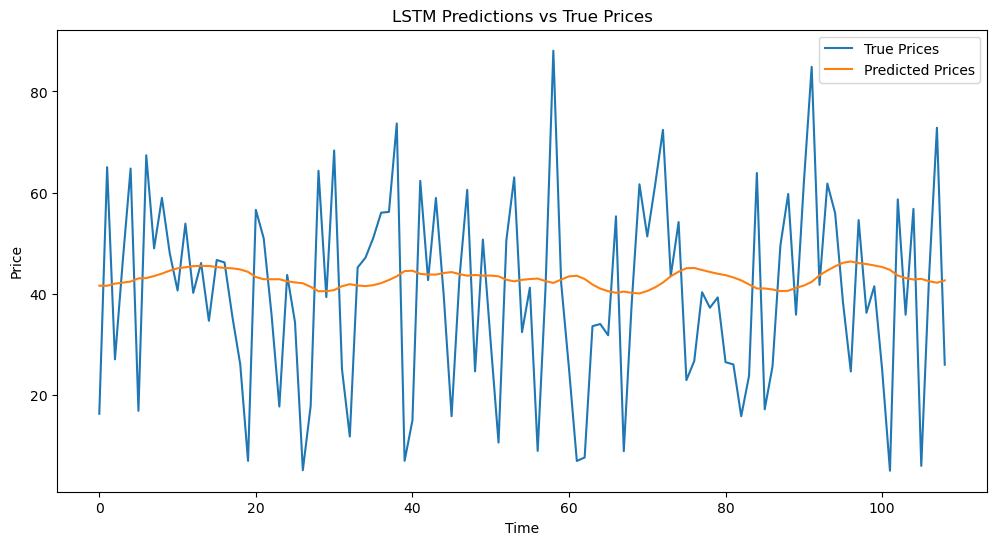

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_true, label='True Prices')
plt.plot(pred, label='Predicted Prices')
plt.title("LSTM Predictions vs True Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [24]:
from sklearn.preprocessing import MinMaxScaler

all_prices = df[PRICE_COL].values.reshape(-1, 1)

scaler = MinMaxScaler()
all_scaled = scaler.fit_transform(all_prices)

In [25]:
split_index = len(train_df)

train_scaled = all_scaled[:split_index]
test_scaled = all_scaled[split_index:]


In [26]:
SEQ_LEN = 50

def create_sequences(data, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN,1)),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20


C:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.0491 - val_loss: 0.0020
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0015 - val_

In [28]:
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)

y_true = df[PRICE_COL].values[split_index + SEQ_LEN:]

print("First 10 predictions:", pred[:10].flatten())
print("First 10 true values:", y_true[:10].flatten())


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step
First 10 predictions: [55.236275 55.445362 55.548824 55.54751  55.485657 55.36596  55.253025
 55.17154  55.254154 55.46668 ]
First 10 true values: [54.18500137 52.3125     51.91500092 52.35499954 52.18500137 53.04249954
 53.49499893 56.01750183 56.28749847 57.07249832]


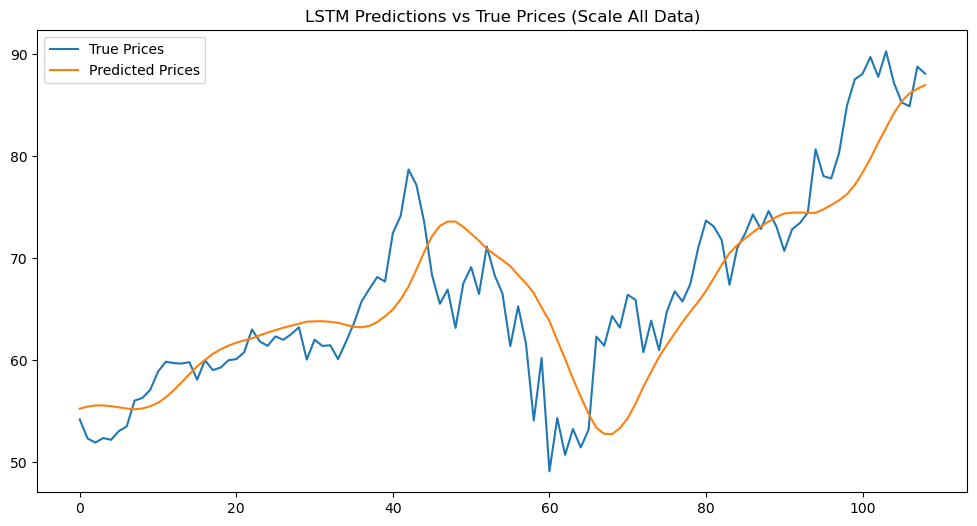

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_true, label='True Prices')
plt.plot(pred, label='Predicted Prices')
plt.legend()
plt.title("LSTM Predictions vs True Prices (Scale All Data)")
plt.show()
